In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253')]

In [6]:
model_path = models_folder / "model_conv_64_16_8_stride_4_B1H_Inst_253"
# For this model I use multiprocessing to train and it broke my "seen indices" 
# I'll be using the train/validation split

# Load model and associated generators

In [7]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
# train_seen_indices = np.load(model_path / "train_seen_indices.npy")
# validation_seen_indices = np.load(model_path / "validation_seen_indices.npy")

# train/validation split
train_split_indices = np.load(model_path / "train_split_indices.npy")
validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_split_indices]
validation_metadata = data_metadata_df.iloc[validation_split_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           7184      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Dec/11 21:40:21 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Dec/11 21:40:21 pyobsbox.generator INFO: batch_size: 8192
Dec/11 21:40:21 pyobsbox.generator INFO: sequence_length: 2048
Dec/11 21:40:21 pyobsbox.generator INFO: n_bunches: 256
Dec/11 21:40:21 pyobsbox.generator INFO: __len__: 41222
Dec/11 21:40:22 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Dec/11 21:40:22 pyobsbox.generator INFO: batch_size: 8192
Dec/11 21:40:22 pyobsbox.generator INFO: sequence_length: 2048
Dec/11 21:40:22 pyobsbox.generator INFO: n_bunches: 256
Dec/11 21:40:22 pyobsbox.generator INFO: __len__: 4581


In [8]:
print(train_metadata.shape)
train_metadata.head()

(10552772, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
1,Inst,7478,1,h,7,2018-11-27 14:49:16,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...,20,0.0,0.0,65536
2,Inst,7478,1,h,7,2018-11-27 14:49:16,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...,20,4.0,1.0,65536
3,Inst,7478,1,h,7,2018-11-27 14:49:16,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...,20,8.0,2.0,65536
4,Inst,7478,1,h,7,2018-11-27 14:49:16,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...,20,12.0,3.0,65536
5,Inst,7478,1,h,7,2018-11-27 14:49:16,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7478/...,20,894.0,4.0,65536


In [9]:
# print(validation_metadata.shape)
# validation_metadata.head()

# Loss functions

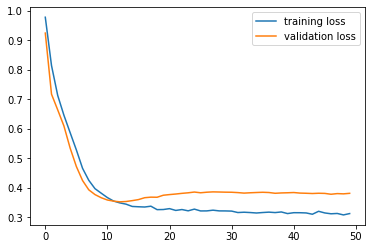

In [10]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [ ]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

In [ ]:
# validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
# validation_dataset.shape

# Predictions

In [ ]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

In [ ]:
# validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
# validation_pred.shape

In [ ]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

In [ ]:
# MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
# MAE_validation.shape

In [ ]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
# plt.yscale('log')

rough peak

In [ ]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

In [ ]:
# plt.figure(figsize=(9, 6))
# n, bins, _ = plt.hist(MAE_validation, bins=100)
# plt.title("validation dataset")

In [ ]:
# hist_peak_validation = bins[n.argmax()]
# hist_peak_validation

In [ ]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [ ]:
max_MAE_indices

In [ ]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

In [ ]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

In [ ]:
for i in range(200):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

In [ ]:
for i in range(1, 101):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [ ]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

In [ ]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [ ]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.27))

In [ ]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()